# Training 

## model 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler


# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model using Vision Transformer with 1 channel for grayscale
model = models.vit_b_16(pretrained=True)
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, kernel_size=16, stride=16)  # Adjust for grayscale
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with Elastic Net regularization (L1 + L2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization is weight_decay
l1_lambda = 1e-4  # L1 regularization

# Define learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Add L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    scheduler.step()
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.6f}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))
print("\nConfusion Matrix:")
print(confusion_matrix(labels, preds))

f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig2.show()

# Save the trained model
torch.save(model.state_dict(), 'vit_chest_xray.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 211MB/s] 


Epoch 1/30, Current Learning Rate: 0.000100


  0%|          | 0/163 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Train Loss: 139.6722, Train Accuracy: 85.14%
Validation Loss: 0.4037, Validation Accuracy: 80.61%
Epoch 2/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Train Loss: 79.5966, Train Accuracy: 91.76%
Validation Loss: 0.4337, Validation Accuracy: 79.33%
Epoch 3/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Train Loss: 46.1640, Train Accuracy: 92.79%
Validation Loss: 0.3615, Validation Accuracy: 85.26%
Epoch 4/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Train Loss: 27.9220, Train Accuracy: 93.75%
Validation Loss: 0.3945, Validation Accuracy: 85.42%
Epoch 5/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


Train Loss: 18.0396, Train Accuracy: 93.50%
Validation Loss: 0.3452, Validation Accuracy: 86.70%
Epoch 6/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Train Loss: 12.5606, Train Accuracy: 94.71%
Validation Loss: 0.4139, Validation Accuracy: 86.22%
Epoch 7/30, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Train Loss: 9.4380, Train Accuracy: 94.50%
Validation Loss: 0.3429, Validation Accuracy: 87.18%
Epoch 8/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Train Loss: 8.0820, Train Accuracy: 96.18%
Validation Loss: 0.3518, Validation Accuracy: 87.34%
Epoch 9/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Train Loss: 7.8738, Train Accuracy: 96.32%
Validation Loss: 0.3810, Validation Accuracy: 87.02%
Epoch 10/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Train Loss: 7.6841, Train Accuracy: 96.38%
Validation Loss: 0.3732, Validation Accuracy: 86.70%
Epoch 11/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Train Loss: 7.4964, Train Accuracy: 96.24%
Validation Loss: 0.3508, Validation Accuracy: 87.50%
Epoch 12/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Train Loss: 7.3132, Train Accuracy: 96.45%
Validation Loss: 0.3749, Validation Accuracy: 85.90%
Epoch 13/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Train Loss: 7.1267, Train Accuracy: 96.55%
Validation Loss: 0.3606, Validation Accuracy: 87.02%
Epoch 14/30, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Train Loss: 6.9506, Train Accuracy: 96.40%
Validation Loss: 0.3482, Validation Accuracy: 87.34%
Epoch 15/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Train Loss: 6.8476, Train Accuracy: 96.36%
Validation Loss: 0.3552, Validation Accuracy: 87.50%
Epoch 16/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Train Loss: 6.8224, Train Accuracy: 96.63%
Validation Loss: 0.3625, Validation Accuracy: 86.70%
Epoch 17/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Train Loss: 6.8054, Train Accuracy: 96.36%
Validation Loss: 0.3688, Validation Accuracy: 86.86%
Epoch 18/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Train Loss: 6.7868, Train Accuracy: 96.43%
Validation Loss: 0.3607, Validation Accuracy: 87.02%
Epoch 19/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Train Loss: 6.7646, Train Accuracy: 96.49%
Validation Loss: 0.3695, Validation Accuracy: 86.86%
Epoch 20/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Train Loss: 6.7489, Train Accuracy: 96.66%
Validation Loss: 0.3697, Validation Accuracy: 86.70%
Epoch 21/30, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Train Loss: 6.7322, Train Accuracy: 96.53%
Validation Loss: 0.3669, Validation Accuracy: 86.86%
Epoch 22/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Train Loss: 6.7202, Train Accuracy: 96.63%
Validation Loss: 0.3637, Validation Accuracy: 86.70%
Epoch 23/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


Train Loss: 6.7176, Train Accuracy: 96.45%
Validation Loss: 0.3625, Validation Accuracy: 86.86%
Epoch 24/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Train Loss: 6.7164, Train Accuracy: 96.43%
Validation Loss: 0.3599, Validation Accuracy: 87.18%
Epoch 25/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Train Loss: 6.7163, Train Accuracy: 96.47%
Validation Loss: 0.3619, Validation Accuracy: 87.02%
Epoch 26/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Train Loss: 6.7108, Train Accuracy: 96.43%
Validation Loss: 0.3630, Validation Accuracy: 86.86%
Epoch 27/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


Train Loss: 6.7084, Train Accuracy: 96.63%
Validation Loss: 0.3639, Validation Accuracy: 86.70%
Epoch 28/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Train Loss: 6.7082, Train Accuracy: 96.49%
Validation Loss: 0.3637, Validation Accuracy: 86.70%
Epoch 29/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Train Loss: 6.7086, Train Accuracy: 96.49%
Validation Loss: 0.3635, Validation Accuracy: 86.70%
Epoch 30/30, Current Learning Rate: 0.000000


100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


Train Loss: 6.7129, Train Accuracy: 96.24%
Validation Loss: 0.3633, Validation Accuracy: 86.70%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.75      0.81       234
   PNEUMONIA       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624


Confusion Matrix:
[[175  59]
 [ 24 366]]
F1 Score: 0.8645
ROC AUC Score: 0.8432


## model 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler


# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model using Vision Transformer with 1 channel for grayscale
model = models.vit_b_16(pretrained=True)
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, kernel_size=16, stride=16)  # Adjust for grayscale
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 512),
    nn.BatchNorm1d(512),  # Added Batch Normalization for better training stability
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),  # Increased model complexity by adding an additional layer
    nn.BatchNorm1d(256),  # Additional Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization is weight_decay

# Define learning rate scheduler - Reduce LR on Plateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.1, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.6f}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))
print("\nConfusion Matrix:")
print(confusion_matrix(labels, preds))

f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig2.show()

# Save the trained model
torch.save(model.state_dict(), 'vit_chest_xray.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 183MB/s]  
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1/10, Current Learning Rate: 0.000100


  0%|          | 0/163 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Train Loss: 0.3318, Train Accuracy: 85.87%
Validation Loss: 0.3827, Validation Accuracy: 84.94%
Epoch 2/10, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Train Loss: 0.2106, Train Accuracy: 91.95%
Validation Loss: 0.4501, Validation Accuracy: 78.69%
Epoch 3/10, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Train Loss: 0.1678, Train Accuracy: 94.08%
Validation Loss: 0.3552, Validation Accuracy: 84.62%
Epoch 4/10, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Train Loss: 0.1615, Train Accuracy: 93.96%
Validation Loss: 0.2393, Validation Accuracy: 91.19%
Epoch 5/10, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Train Loss: 0.1358, Train Accuracy: 94.84%
Validation Loss: 0.6498, Validation Accuracy: 73.40%
Epoch 6/10, Current Learning Rate: 0.000100


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Train Loss: 0.1394, Train Accuracy: 94.46%
Validation Loss: 0.3652, Validation Accuracy: 87.98%
Epoch 7/10, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Train Loss: 0.1164, Train Accuracy: 96.22%
Validation Loss: 0.2474, Validation Accuracy: 90.54%
Epoch 8/10, Current Learning Rate: 0.000010


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Train Loss: 0.1052, Train Accuracy: 96.34%
Validation Loss: 0.2648, Validation Accuracy: 90.06%
Epoch 9/10, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Train Loss: 0.0967, Train Accuracy: 96.72%
Validation Loss: 0.2594, Validation Accuracy: 90.06%
Epoch 10/10, Current Learning Rate: 0.000001


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Train Loss: 0.0974, Train Accuracy: 96.74%
Validation Loss: 0.2428, Validation Accuracy: 91.35%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.88      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624


Confusion Matrix:
[[184  50]
 [ 10 380]]
F1 Score: 0.9128
ROC AUC Score: 0.9009


## model 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model using Vision Transformer with 1 channel for grayscale
model = models.vit_b_16(pretrained=True)
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, kernel_size=16, stride=16)  # Adjust for grayscale
# Adding additional complexity by increasing hidden layers and applying Batch Normalization
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 1024),  # Increased hidden units for complexity
    nn.BatchNorm1d(1024),  # Batch normalization to avoid overfitting
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),  # Adding BatchNorm to regularize
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization (Elastic Net removed)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization is weight_decay

# Define learning rate scheduler with ReduceLROnPlateau (patience = 1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Print the current learning rate in scientific notation (1e-4)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.1e}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix with labels
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig2.show()

# Save the trained model
torch.save(model.state_dict(), 'vit_chest_xray.pth')


## model 4

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model using Vision Transformer with 1 channel for grayscale
weights = ViT_B_16_Weights.IMAGENET1K_V1  # Updated for the weights argument
model = models.vit_b_16(weights=weights)  # Changed from pretrained=True to weights
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, kernel_size=16, stride=16)  # Adjust for grayscale

# Increase complexity of the model
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 2048),  # Increased hidden units
    nn.BatchNorm1d(2048),  # Batch normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),  # Extra layer
    nn.BatchNorm1d(1024),  # Batch normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),   # Added more complexity
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)       # Output layer
)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define learning rate scheduler with ReduceLROnPlateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):  # Updated amp.autocast usage
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast(device_type='cuda'):  # Updated amp.autocast usage
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.1e}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix with labels
conf_matrix = confusion_matrix(labels, preds)
z_text = [[str(y) for y in x] for x in conf_matrix]

# Plot confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    conf_matrix, 
    x=['NORMAL', 'PNEUMONIA'], 
    y=['NORMAL', 'PNEUMONIA'], 
    annotation_text=z_text, 
    colorscale='Blues'
)
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual'
)
fig['data'][0]['showscale'] = True
fig.show()

# F1 Score and ROC AUC Score
f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy (%)')
fig2.show()


Epoch 1/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Train Loss: 0.3264, Train Accuracy: 85.37%
Validation Loss: 0.9078, Validation Accuracy: 63.14%
Epoch 2/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Train Loss: 0.2044, Train Accuracy: 92.35%
Validation Loss: 0.4588, Validation Accuracy: 77.08%
Epoch 3/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Train Loss: 0.1689, Train Accuracy: 93.37%
Validation Loss: 0.3948, Validation Accuracy: 85.26%
Epoch 4/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Train Loss: 0.1609, Train Accuracy: 93.87%
Validation Loss: 0.2624, Validation Accuracy: 87.98%
Epoch 5/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Train Loss: 0.1504, Train Accuracy: 94.65%
Validation Loss: 0.3649, Validation Accuracy: 86.54%
Epoch 6/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


Train Loss: 0.1438, Train Accuracy: 94.65%
Validation Loss: 0.3063, Validation Accuracy: 88.94%
Epoch 7/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Train Loss: 0.1211, Train Accuracy: 95.67%
Validation Loss: 0.2398, Validation Accuracy: 90.87%
Epoch 8/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Train Loss: 0.1037, Train Accuracy: 96.11%
Validation Loss: 0.2498, Validation Accuracy: 90.54%
Epoch 9/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Train Loss: 0.1072, Train Accuracy: 96.28%
Validation Loss: 0.2347, Validation Accuracy: 90.54%
Epoch 10/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

Train Loss: 0.1028, Train Accuracy: 96.38%
Validation Loss: 0.2437, Validation Accuracy: 90.06%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.82      0.86       234
   PNEUMONIA       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



F1 Score: 0.8996
ROC AUC Score: 0.8846


## model 5

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model using Vision Transformer with 1 channel for grayscale
weights = ViT_B_16_Weights.IMAGENET1K_V1  # Updated for the weights argument
model = models.vit_b_16(weights=weights)  # Changed from pretrained=True to weights
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, kernel_size=16, stride=16)  # Adjust for grayscale

# Increase complexity of the model 
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 2048),  # Increased hidden units
    nn.BatchNorm1d(2048),  # Batch normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),  # Extra layer
    nn.BatchNorm1d(1024),  # Batch normalization
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),   # More complexity
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),    # New added layer
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),    # Another added layer
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)       # Output layer
)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define learning rate scheduler with ReduceLROnPlateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Updated amp.autocast usage
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):  # Updated amp.autocast usage
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.1e}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix with labels
conf_matrix = confusion_matrix(labels, preds)
z_text = [[str(y) for y in x] for x in conf_matrix]

# Plot confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    conf_matrix, 
    x=['NORMAL', 'PNEUMONIA'], 
    y=['NORMAL', 'PNEUMONIA'], 
    annotation_text=z_text, 
    colorscale='Blues'
)
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual'
)
fig['data'][0]['showscale'] = True
fig.show()

# F1 Score and ROC AUC Score
f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy (%)')
fig2.show()


Epoch 1/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Train Loss: 0.6306, Train Accuracy: 62.35%
Validation Loss: 0.7035, Validation Accuracy: 49.84%
Epoch 2/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Train Loss: 0.3772, Train Accuracy: 84.45%
Validation Loss: 0.5082, Validation Accuracy: 73.08%
Epoch 3/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Train Loss: 0.2668, Train Accuracy: 90.45%
Validation Loss: 0.3572, Validation Accuracy: 83.97%
Epoch 4/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Train Loss: 0.2286, Train Accuracy: 92.18%
Validation Loss: 0.9186, Validation Accuracy: 56.25%
Epoch 5/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Train Loss: 0.2044, Train Accuracy: 92.98%
Validation Loss: 0.7041, Validation Accuracy: 67.79%
Epoch 6/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


Train Loss: 0.1858, Train Accuracy: 93.62%
Validation Loss: 0.3146, Validation Accuracy: 88.30%
Epoch 7/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Train Loss: 0.1720, Train Accuracy: 94.54%
Validation Loss: 0.3175, Validation Accuracy: 87.50%
Epoch 8/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


Train Loss: 0.1674, Train Accuracy: 94.96%
Validation Loss: 0.3122, Validation Accuracy: 88.30%
Epoch 9/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Train Loss: 0.1560, Train Accuracy: 95.53%
Validation Loss: 0.3069, Validation Accuracy: 88.62%
Epoch 10/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.62it/s]

Train Loss: 0.1500, Train Accuracy: 95.65%
Validation Loss: 0.2898, Validation Accuracy: 88.78%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.81      0.84       234
   PNEUMONIA       0.89      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



F1 Score: 0.8868
ROC AUC Score: 0.8726


## model 6

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.RandomHorizontalFlip(),            # Data augmentation
    transforms.RandomRotation(10),                # Data augmentation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model for feature extraction
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
    
    def forward(self, x):
        x = self.features(x)
        return x

# Define a custom Vision Transformer model
class CustomViT(nn.Module):
    def __init__(self):
        super(CustomViT, self).__init__()
        self.vit = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.vit.conv_proj = nn.Conv2d(256, self.vit.conv_proj.out_channels, kernel_size=16, stride=16)
    
    def forward(self, x):
        x = self.vit(x)
        return x

# Initialize CNN and Vision Transformer models
cnn_model = CNNFeatureExtractor().to(device)
vit_model = CustomViT().to(device)

# Combine CNN and Vision Transformer
class HybridModel(nn.Module):
    def __init__(self, cnn_model, vit_model):
        super(HybridModel, self).__init__()
        self.cnn = cnn_model
        self.vit = vit_model
    
    def forward(self, x):
        x = self.cnn(x)
        # Ensure the input size to Vision Transformer is [batch_size, channels, height, width]
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.vit(x)
        return x

# Initialize hybrid model
model = HybridModel(cnn_model, vit_model)
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define learning rate scheduler with ReduceLROnPlateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {current_lr:.1e}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step(val_loss)

# Calculate and print classification metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix with labels
conf_matrix = confusion_matrix(labels, preds)
z_text = [[str(y) for y in x] for x in conf_matrix]

# Plot confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    conf_matrix, 
    x=['NORMAL', 'PNEUMONIA'], 
    y=['NORMAL', 'PNEUMONIA'], 
    annotation_text=z_text, 
    colorscale='Blues'
)
fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='Actual'
)
fig['data'][0]['showscale'] = True
fig.show()

# F1 Score and ROC AUC Score
f1 = f1_score(labels, preds, average='weighted')
roc_auc = roc_auc_score(labels, preds)
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot loss and accuracy
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Train Loss'))
fig1.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation Loss'))
fig1.update_layout(title='Training vs Validation Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_accuracies, mode='lines', name='Train Accuracy'))
fig2.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_accuracies, mode='lines', name='Validation Accuracy'))
fig2.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy (%)')
fig2.show()


Epoch 1/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


Train Loss: 0.5314, Train Accuracy: 76.94%
Validation Loss: 0.4089, Validation Accuracy: 83.65%
Epoch 2/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Train Loss: 0.2838, Train Accuracy: 88.00%
Validation Loss: 0.3501, Validation Accuracy: 85.26%
Epoch 3/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Train Loss: 0.2331, Train Accuracy: 90.74%
Validation Loss: 0.3590, Validation Accuracy: 87.02%
Epoch 4/10, Current Learning Rate: 1.0e-04


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


Train Loss: 0.1853, Train Accuracy: 93.04%
Validation Loss: 0.7071, Validation Accuracy: 76.60%
Epoch 5/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Train Loss: 0.1268, Train Accuracy: 95.03%
Validation Loss: 0.4340, Validation Accuracy: 85.58%
Epoch 6/10, Current Learning Rate: 1.0e-05


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Train Loss: 0.1181, Train Accuracy: 95.48%
Validation Loss: 0.3684, Validation Accuracy: 86.70%
Epoch 7/10, Current Learning Rate: 1.0e-06


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Train Loss: 0.1127, Train Accuracy: 95.53%
Validation Loss: 0.3923, Validation Accuracy: 86.38%
Epoch 8/10, Current Learning Rate: 1.0e-06


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Train Loss: 0.1136, Train Accuracy: 95.63%
Validation Loss: 0.4008, Validation Accuracy: 86.06%
Epoch 9/10, Current Learning Rate: 1.0e-07


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Train Loss: 0.1159, Train Accuracy: 95.72%
Validation Loss: 0.4053, Validation Accuracy: 86.22%
Epoch 10/10, Current Learning Rate: 1.0e-07


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Train Loss: 0.1165, Train Accuracy: 95.59%
Validation Loss: 0.4067, Validation Accuracy: 86.06%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.70      0.79       234
   PNEUMONIA       0.84      0.96      0.90       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



F1 Score: 0.8561
ROC AUC Score: 0.8286


## model 7

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ViT_B_16_Weights
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import plotly.graph_objects as go
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler

# Define a custom dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = [(os.path.join(root, file), 0 if 'NORMAL' in root else 1)
                           for root, _, files in os.walk(img_dir) for file in files]
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Set up the transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize the dataset and dataloaders
train_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = ChestXRayDataset('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model for feature extraction
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
    
    def forward(self, x):
        x = self.features(x)
        return x

# Define a custom Vision Transformer model
class CustomViT(nn.Module):
    def __init__(self):
        super(CustomViT, self).__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = models.vit_b_16(weights=weights)
        
        self.vit.conv_proj = nn.Conv2d(256, self.vit.conv_proj.out_channels, kernel_size=16, stride=16)

        self.vit.heads = nn.Sequential(
            nn.Linear(self.vit.heads.head.in_features, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        x = self.vit(x)
        return x

# Combine CNN and Vision Transformer
class HybridModel(nn.Module):
    def __init__(self, cnn_model, vit_model):
        super(HybridModel, self).__init__()
        self.cnn = cnn_model
        self.vit = vit_model
    
    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, start_dim=1)
        x = x.view(x.size(0), 256, 14, 14)
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = x.view(x.size(0), 256, 224, 224)
        x = self.vit(x)
        return x

# Initialize CNN and Vision Transformer models
cnn_model = CNNFeatureExtractor().to(device)
vit_model = CustomViT().to(device)

# Initialize hybrid model
model = HybridModel(cnn_model, vit_model)
model = nn.DataParallel(model)
model = model.to(device)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define learning rate scheduler with ReduceLROnPlateau
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / total
    return train_loss, accuracy

# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(test_loader)
    accuracy = 100. * correct / total
    return val_loss, accuracy, all_preds, all_labels

# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    val_loss, val_acc, all_preds, all_labels = validate(model, test_loader, criterion)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Print learning rate
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(f"Learning Rate: {lr:.1e}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Calculate and print confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Print classification report
report = classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:")
print(report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Calculate F1 Score
f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1:.4f}")

# Plotting using Plotly
# Training and validation loss
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_losses, mode='lines+markers', name='Train Loss'))
fig_loss.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=val_losses, mode='lines+markers', name='Validation Loss'))
fig_loss.update_layout(title='Train and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss.show()

# Training and validation accuracy
fig_acc = go.Figure()
fig_acc.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=train_accuracies, mode='lines+markers', name='Train Accuracy'))
fig_acc.add_trace(go.Scatter(x=list(range(1, num_epochs + 1)), y=val_accuracies, mode='lines+markers', name='Validation Accuracy'))
fig_acc.update_layout(title='Train and Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy (%)')
fig_acc.show()

# Confusion matrix
fig_cm = go.Figure(data=go.Heatmap(z=cm, x=['NORMAL', 'PNEUMONIA'], y=['NORMAL', 'PNEUMONIA'], colorscale='Viridis', colorbar=dict(title='Count')))
fig_cm.update_layout(title='Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='True Label')
fig_cm.show()


Epoch 1/10


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Learning Rate: 1.0e-04
Train Loss: 0.5034, Train Accuracy: 75.23%
Validation Loss: 0.4166, Validation Accuracy: 82.53%
Epoch 2/10


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Learning Rate: 1.0e-04
Train Loss: 0.3035, Train Accuracy: 89.28%
Validation Loss: 0.3201, Validation Accuracy: 86.22%
Epoch 3/10


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Learning Rate: 1.0e-04
Train Loss: 0.2309, Train Accuracy: 91.87%
Validation Loss: 0.5809, Validation Accuracy: 73.72%
Epoch 4/10


100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


Learning Rate: 1.0e-05
Train Loss: 0.2065, Train Accuracy: 92.89%
Validation Loss: 0.3542, Validation Accuracy: 85.26%
Epoch 5/10


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Learning Rate: 1.0e-05
Train Loss: 0.1699, Train Accuracy: 94.54%
Validation Loss: 0.2961, Validation Accuracy: 88.14%
Epoch 6/10


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Learning Rate: 1.0e-05
Train Loss: 0.1677, Train Accuracy: 94.50%
Validation Loss: 0.2827, Validation Accuracy: 89.26%
Epoch 7/10


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Learning Rate: 1.0e-05
Train Loss: 0.1733, Train Accuracy: 94.44%
Validation Loss: 0.3183, Validation Accuracy: 87.66%
Epoch 8/10


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


Learning Rate: 1.0e-06
Train Loss: 0.1543, Train Accuracy: 95.46%
Validation Loss: 0.2993, Validation Accuracy: 88.30%
Epoch 9/10


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Learning Rate: 1.0e-06
Train Loss: 0.1647, Train Accuracy: 94.90%
Validation Loss: 0.3526, Validation Accuracy: 85.74%
Epoch 10/10


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

Learning Rate: 1.0e-07
Train Loss: 0.1617, Train Accuracy: 94.59%
Validation Loss: 0.3279, Validation Accuracy: 87.66%
Confusion Matrix:
[[163  71]
 [  6 384]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.70      0.81       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624

ROC AUC Score: 0.8406
F1 Score: 0.9089


# XAI

## attention maps 

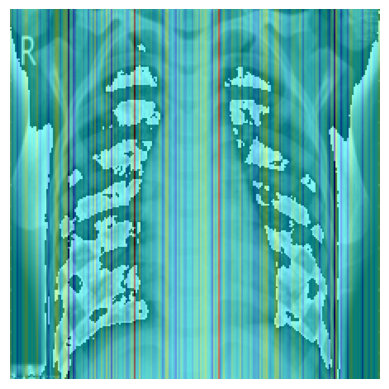

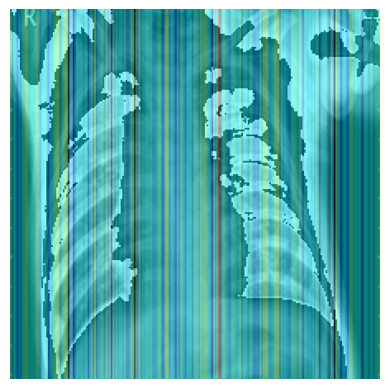

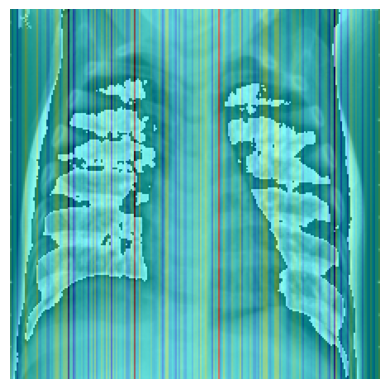

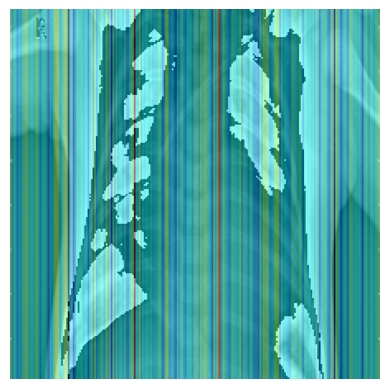

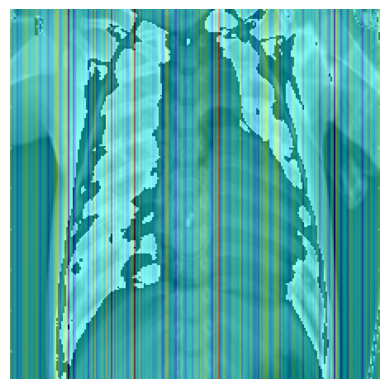

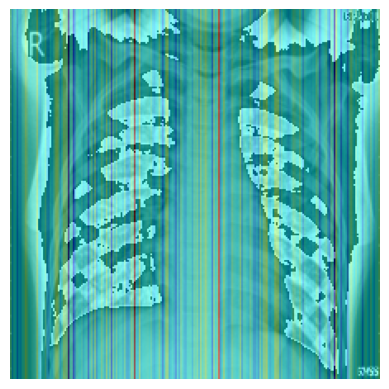

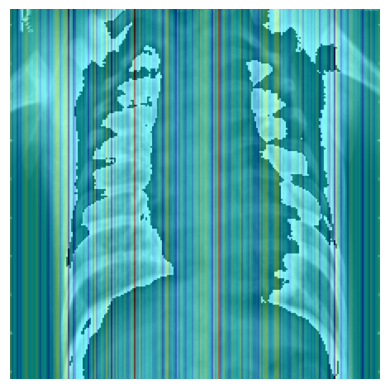

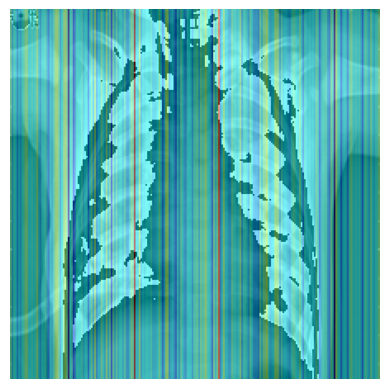

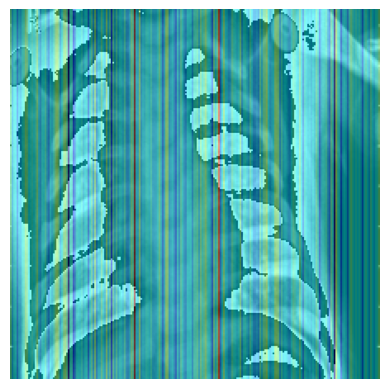

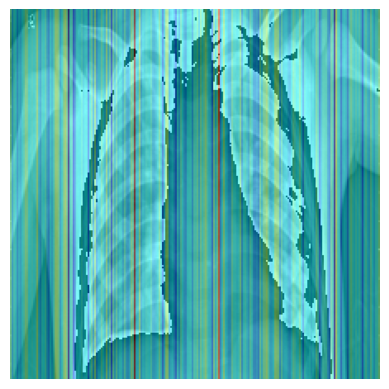

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

def show_attention_map(image, attention_map):
    # Resize attention map to the original image size
    attention_map_resized = cv2.resize(attention_map, (image.size[1], image.size[0]))
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())
    attention_map_resized = np.uint8(255 * attention_map_resized)
    attention_map_colored = cv2.applyColorMap(attention_map_resized, cv2.COLORMAP_JET)
    
    # Convert grayscale image to RGB
    image_rgb = np.array(image.convert("RGB"))  # Convert PIL image to RGB format
    overlayed_img = image_rgb * 0.5 + attention_map_colored * 0.5
    overlayed_img = np.clip(overlayed_img, 0, 255).astype(np.uint8)
    
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.show()

def visualize_attention(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    attention_weights = []

    def get_attention_weights(module, input, output):
        attention_weights.append(output)

    hooks = []
    for layer in model.module.encoder.layers:
        hook = layer.register_forward_hook(get_attention_weights)
        hooks.append(hook)

    with torch.no_grad():
        _ = model(image)

    attn_weights = attention_weights[-1].detach().cpu().numpy()

    

    if attn_weights.ndim == 3:  # If there are multiple heads
        attn_weights = attn_weights.mean(axis=1)  # Average across heads if needed

    # Number of patches excluding CLS token
    num_patches = attn_weights.shape[1] - 1  # Exclude the CLS token

    # Calculate the grid dimensions
    for height in range(1, num_patches + 1):
        if num_patches % height == 0:
            width = num_patches // height
            break

    cls_attention_map = attn_weights[0, 1:].reshape(height, width)

    for hook in hooks:
        hook.remove()

    image_pil = transforms.ToPILImage()(image.squeeze(0).cpu())
    show_attention_map(image_pil, cls_attention_map)

for i in range(0,10):
    
    example_image, _ = test_dataset[i]  
    visualize_attention(model, example_image, device)


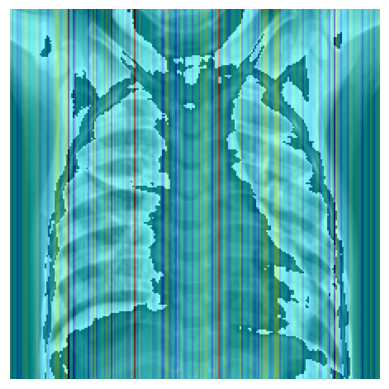

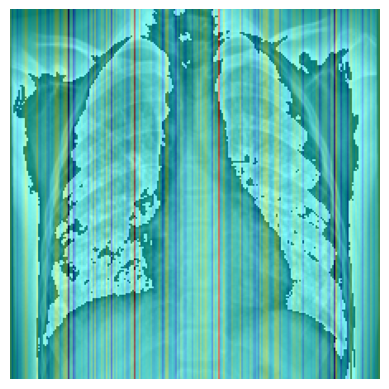

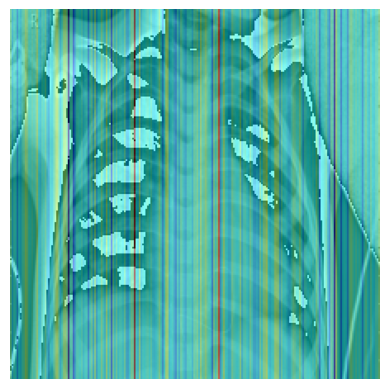

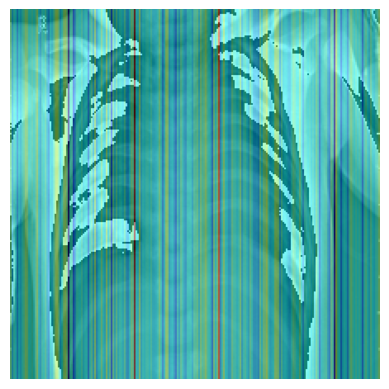

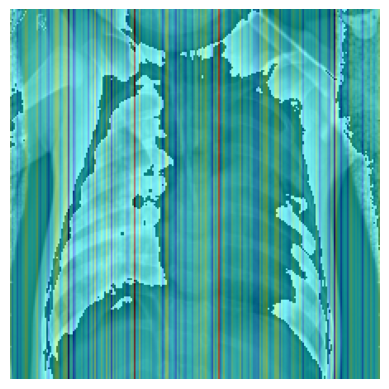

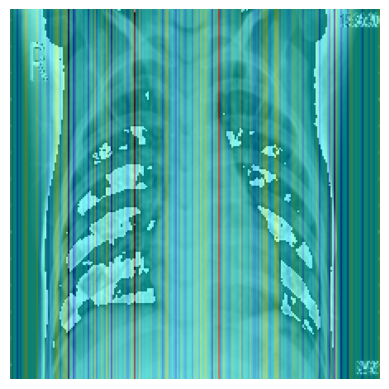

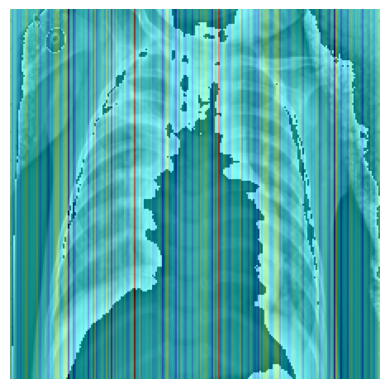

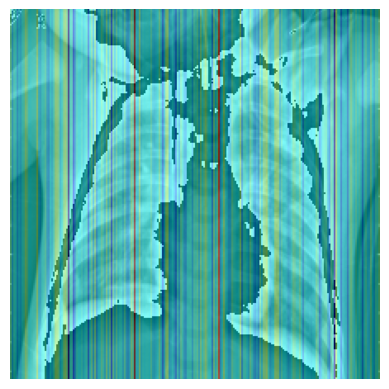

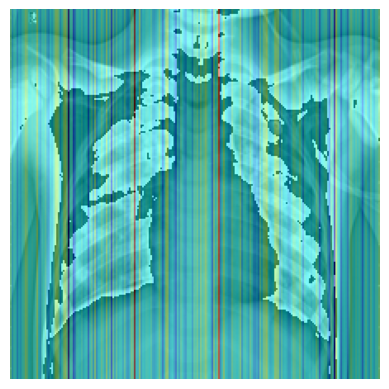

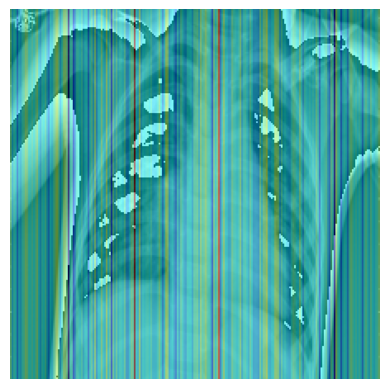

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

def show_attention_map(image, attention_map):
    # Resize attention map to the original image size
    attention_map_resized = cv2.resize(attention_map, (image.size[1], image.size[0]))
    attention_map_resized = (attention_map_resized - attention_map_resized.min()) / (attention_map_resized.max() - attention_map_resized.min())
    attention_map_resized = np.uint8(255 * attention_map_resized)
    attention_map_colored = cv2.applyColorMap(attention_map_resized, cv2.COLORMAP_JET)
    
    # Convert grayscale image to RGB
    image_rgb = np.array(image.convert("RGB"))  # Convert PIL image to RGB format
    overlayed_img = image_rgb * 0.5 + attention_map_colored * 0.5
    overlayed_img = np.clip(overlayed_img, 0, 255).astype(np.uint8)
    
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.show()

def visualize_attention(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    attention_weights = []

    def get_attention_weights(module, input, output):
        attention_weights.append(output)

    hooks = []
    for layer in model.module.encoder.layers:
        hook = layer.register_forward_hook(get_attention_weights)
        hooks.append(hook)

    with torch.no_grad():
        _ = model(image)

    attn_weights = attention_weights[-1].detach().cpu().numpy()

    

    if attn_weights.ndim == 3:  # If there are multiple heads
        attn_weights = attn_weights.mean(axis=1)  # Average across heads if needed

    # Number of patches excluding CLS token
    num_patches = attn_weights.shape[1] - 1  # Exclude the CLS token

    # Calculate the grid dimensions
    for height in range(1, num_patches + 1):
        if num_patches % height == 0:
            width = num_patches // height
            break

    cls_attention_map = attn_weights[0, 1:].reshape(height, width)

    for hook in hooks:
        hook.remove()

    image_pil = transforms.ToPILImage()(image.squeeze(0).cpu())
    show_attention_map(image_pil, cls_attention_map)

for i in range(10,20):
    
    example_image, _ = test_dataset[i]  
    visualize_attention(model, example_image, device)
